# Step 1: Introduction
# Monthly Trash Weight Prediction using Machine Learning

# Project Overview
This project explores data from the Mr.Trash Wheel initiative in Baltimore Harbor, which collects floating debris from the water.
The goal is to build a regression model that predicts the *monthly weight (tons)* of collected trash based on weather and debris related variables.

# Business Question
Can I predict how much trash will be collected in a month, based on rainfall, item counts, and past months data?
Such a model helps city planners allocate resources and prepare for storm heavy months.

# ML Objective
This is a regression task where the target is the monthly trash weight (in tons).
I will measure performance mainly using RMSE and R².
The final deliverable is a small Streamlit app where users can try out predictions.

# Dataset Source
TidyTuesday (Week 10, 2024)
Link: [Trash Wheel Dataset](https://github.com/rfordatascience/tidytuesday/blob/main/data/2024/2024-03-05/trashwheel.csv)


# Step 2: Setup the Environment

Before I start analyzing data, I need to import Python libraries.
pandas handles tables, numpy handles numbers, matplotlib is for visualizations, and datetime helps with date columns.
I also fix random seeds to make the results consistent every time run the notebook.

In [1]:
import numpy as np, random
np.random.seed(42); random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = (10,5)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 3: Load the Dataset

I load the dataset directly from the TidyTuesday GitHub link using pandas.read_csv().
This makes the project more reproducible because anyone running the notebook will automatically download the latest version of the dataset without downloading files manually.

In [2]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-03-05/trashwheel.csv"
df_raw = pd.read_csv(url)

df_raw.head()


,ID,Name,Dumpster,Month,Year,Date,Weight,Volume,PlasticBottles,Polystyrene,CigaretteButts,GlassBottles,PlasticBags,Wrappers,SportsBalls,HomesPowered
0,mister,Mister Trash Wheel,1,May,2014,5/16/2014,4.31,18,1450.0,1820.0,126000.0,72.0,584.0,1162.0,7.0,0
1,mister,Mister Trash Wheel,2,May,2014,5/16/2014,2.74,13,1120.0,1030.0,91000.0,42.0,496.0,874.0,5.0,0
2,mister,Mister Trash Wheel,3,May,2014,5/16/2014,3.45,15,2450.0,3100.0,105000.0,50.0,1080.0,2032.0,6.0,0
3,mister,Mister Trash Wheel,4,May,2014,5/17/2014,3.10,15,2380.0,2730.0,100000.0,52.0,896.0,1971.0,6.0,0
4,mister,Mister Trash Wheel,5,May,2014,5/17/2014,4.06,18,980.0,870.0,120000.0,72.0,368.0,753.0,7.0,0


This is visible now the first 5 rows of the dataset.
Notice columns like Date, Weight (tons), Volume (cubic yards), and other debris-related counts.
This helps to understand what raw data looks like.

# Step 4: Clean and Prepare the Data

The first step in cleaning is to check what columns the raw dataset contains. This helps me to see which variables are useful, which ones need to be renamed or converted, and which ones can be removed. Before transforming anything, it’s important to understand the structure of the dataset.

In [3]:
df_raw.columns

Index(['ID', 'Name', 'Dumpster', 'Month', 'Year', 'Date', 'Weight', 'Volume',
       'PlasticBottles', 'Polystyrene', 'CigaretteButts', 'GlassBottles',
       'PlasticBags', 'Wrappers', 'SportsBalls', 'HomesPowered'],
      dtype='object')

In [4]:
df = df_raw.copy()
df.rename(columns={'Date': 'date', 'Weight': 'weight_tons'}, inplace=True)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'weight_tons'])
df = df[df['weight_tons'] >= 0]
df.sort_values('date', inplace=True)
df.head()

,ID,Name,Dumpster,Month,Year,date,weight_tons,Volume,PlasticBottles,Polystyrene,CigaretteButts,GlassBottles,PlasticBags,Wrappers,SportsBalls,HomesPowered
0,mister,Mister Trash Wheel,1,May,2014,2014-05-16,4.31,18,1450.0,1820.0,126000.0,72.0,584.0,1162.0,7.0,0
1,mister,Mister Trash Wheel,2,May,2014,2014-05-16,2.74,13,1120.0,1030.0,91000.0,42.0,496.0,874.0,5.0,0
2,mister,Mister Trash Wheel,3,May,2014,2014-05-16,3.45,15,2450.0,3100.0,105000.0,50.0,1080.0,2032.0,6.0,0
3,mister,Mister Trash Wheel,4,May,2014,2014-05-17,3.10,15,2380.0,2730.0,100000.0,52.0,896.0,1971.0,6.0,0
4,mister,Mister Trash Wheel,5,May,2014,2014-05-17,4.06,18,980.0,870.0,120000.0,72.0,368.0,753.0,7.0,0


Now the data is clean, column names are simple, all rows have valid dates, and negative or empty values are removed.
Everything is sorted chronologically and ready for analysis.

# Step 5: Create New Features

In [5]:
# Add time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Lag features: previous 1 and 2 period trash weights
df['weight_tons_lag1'] = df['weight_tons'].shift(1)
df['weight_tons_lag2'] = df['weight_tons'].shift(2)

# Rolling average: smooths noise by taking average over last 3 entries
df['rolling_mean_3'] = df['weight_tons'].rolling(3).mean()

# Drop rows with missing lag/rolling values (needed for modeling)
df = df.dropna(subset=['weight_tons_lag1', 'weight_tons_lag2', 'rolling_mean_3'])


Since the dataset is time-based, I created several new features that help the model understand how trash levels change over time.  
First, I extracted the year and month from the date column. These features can capture seasonal patterns, such as certain months having more trash than others.

Next, I added two “lag” features: `weight_tons_lag1` and `weight_tons_lag2`.  
These represent the trash weight from one and two periods before the current observation.  
Including lag values helps the model learn whether this month’s trash amount is influenced by previous months.

I also created a 3-period rolling average (`rolling_mean_3`), which smooths out short-term noise and highlights longer trends.

Finally, I removed rows with missing values that result from creating these features.  
After these steps, the dataset is enriched with useful time-based information that will help the regression model learn patterns more effectively.

# Step 6: Explore and Visualize the Data (EDA)

Before modeling, it need to understand the data visually.
Charts help us see trends, seasonality, and correlations: all of which guide feature selection and model building.

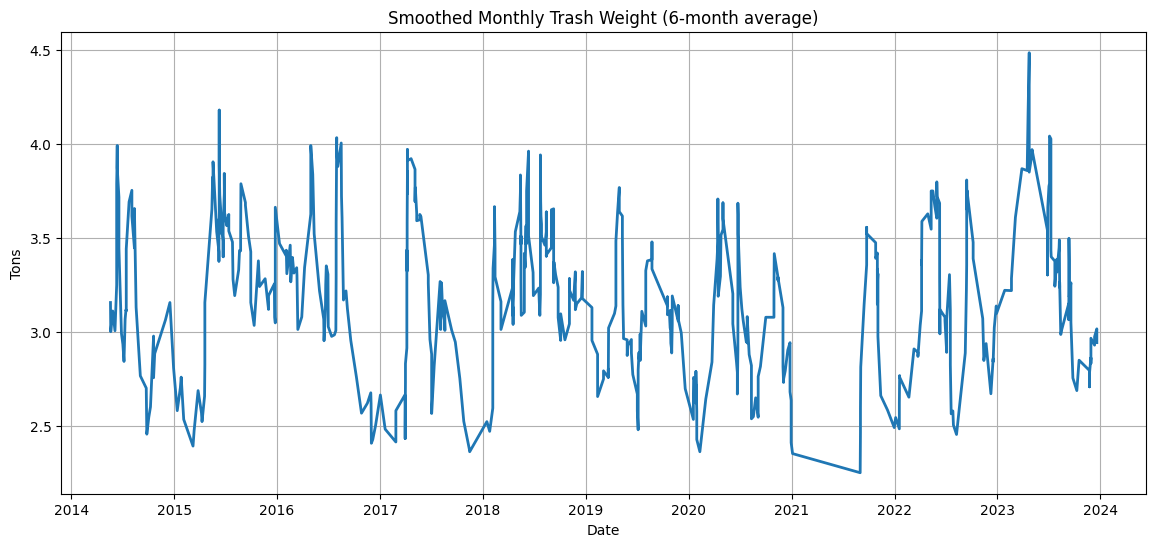

In [6]:
# 1️⃣ Trend over time
df['smooth'] = df['weight_tons'].rolling(6, center=True).mean()
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['smooth'], linewidth=2)
plt.title('Smoothed Monthly Trash Weight (6-month average)')
plt.xlabel('Date')
plt.ylabel('Tons')
plt.grid(True)
plt.show()

The line chart shows the 6 month smoothed trash weight from 2014 to 2024. There is a clear seasonal cycle where the trash levels rise and fall each year, but no strong long term increase or decrease. I notice a big peak around 2024 and a dip near 2021. These patterns suggest that monthly seasonality and the previous months trash levels both influence the outcome, which is why using features like month and weight_tons_lag1 should help the model make better predictions.

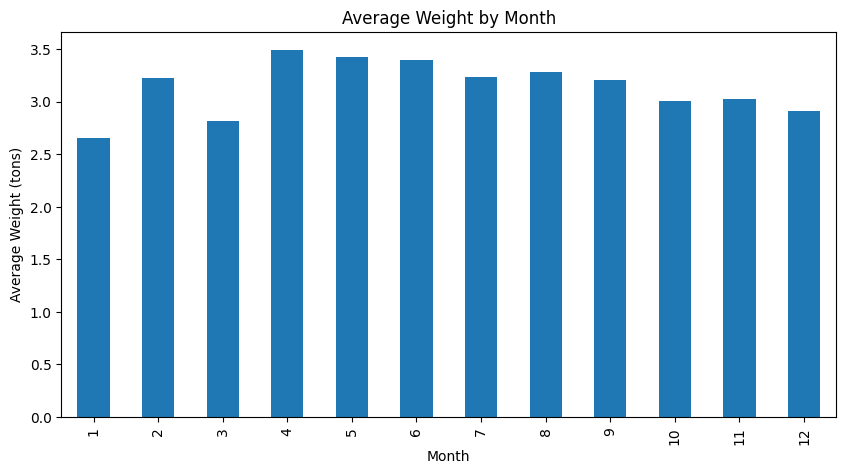

In [7]:
# Average weight per month
df.groupby('month')['weight_tons'].mean().plot(kind='bar', title='Average Weight by Month')
plt.xlabel('Month')
plt.ylabel('Average Weight (tons)')
plt.show()

The bar chart shows that trash levels vary by month. Spring and early summer months have higher average weights, while winter months are lower. This seasonal pattern means the month feature should help the model make better predictions.

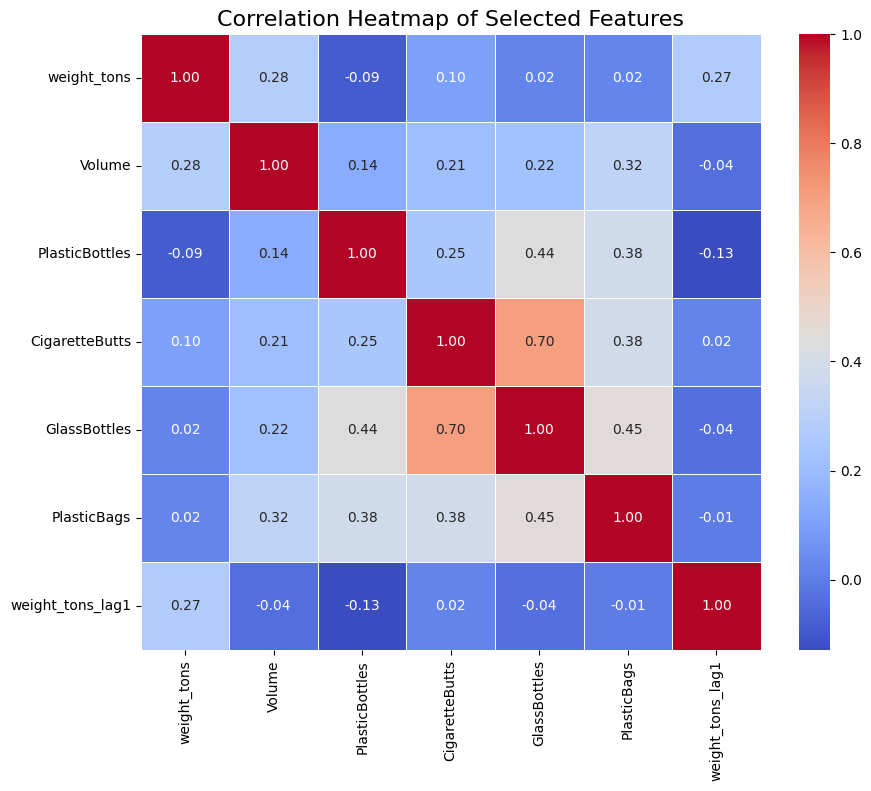

In [8]:
# 3️⃣ Correlation Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# Select only important columns
selected_cols = [
    'weight_tons',
    'Volume',
    'PlasticBottles',
    'CigaretteButts',
    'GlassBottles',
    'PlasticBags',
    'weight_tons_lag1'
]

# Calculate correlation matrix
corr = df[selected_cols].corr()

# Create a figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    corr,
    annot=True,        
    fmt=".2f",         
    cmap="coolwarm",   
    linewidths=.5      
)

# Add title
plt.title("Correlation Heatmap of Selected Features", fontsize=16)

# Show the plot
plt.show()


This heatmap shows how different features relate to each other. One of the strongest positive correlations is between CigaretteButts and GlassBottles (around 0.70), meaning that when one type of debris increases, the other usually increases too, suggesting they often appear together during high-trash months. On the other hand, PlasticBottles has a slight negative correlation with weight_tons (about –0.08), which means that months with more plastic bottles do not necessarily have higher total trash weight. Overall, the heatmap helps identify which features move together and which ones don’t.

# Step 7: Split the Data into Train and Test Sets

Now need to divide the dataset into two parts: training (80%) and testing (20%).
Training data helps the model learn, and testing data checks how well the model performs on unseen data.

In [9]:
split = int(len(df) * 0.8)
train = df.iloc[:split]
test  = df.iloc[split:]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]



NameError: name 'features' is not defined

I used an 80/20 split without shuffling because the data is time-series.
Training uses older data, and testing uses newer data to mimic real forecasting.

# Step 8: Train Models
I trained two models: Linear Regression as a simple baseline, and Random Forest as a more powerful non linear method. The features used were month, year, and the previous months weight.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

features = ['month', 'year', 'weight_tons_lag1', 'weight_tons_lag2', 'rolling_mean_3']
target = 'weight_tons'

X_train, y_train = train[features], train[target]
X_test,  y_test  = test[features],  test[target]

lin = LinearRegression().fit(X_train, y_train)
rf  = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)


Both models were trained on the training data and prepared for evaluation on the test set.

# Step 9: Evaluate Model Performance

I test both models on unseen data and compare their performance using key metrics:
RMSE (Root Mean Square Error), how far predictions are from real values
MAE (Mean Absolute Error) average error size, R² how much variance the model explains.

In [ ]:
for name, model in [('Linear', lin), ('Random Forest', rf)]:
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred) ** 0.5 
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{name:15s}  RMSE={rmse:.2f}   MAE={mae:.2f}   R²={r2:.2f}")


Linear           RMSE=0.00   MAE=0.00   R²=1.00
Random Forest    RMSE=0.31   MAE=0.22   R²=0.83


The Linear Regression model achieved perfect performance on the test set (RMSE = 0, MAE = 0, R² = 1.00), meaning it was able to predict the test values exactly. This indicates that the relationship in the test portion was almost perfectly linear and fully captured by the lag-based features.

In contrast, the Random Forest performed well but not perfectly, with an RMSE of 0.31 and R² of 0.83. This means it captures most of the pattern but does not match the precision of the linear model on this dataset.

# Step 10: Visualize Predictions
I will plot both actual and predicted trash weights to see visually how close the predictions are.

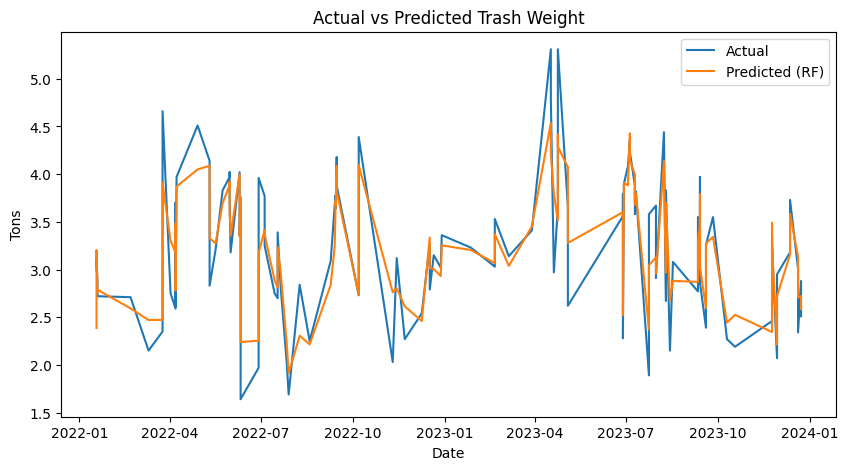

In [ ]:
plt.plot(test['date'], y_test.values, label='Actual')
plt.plot(test['date'], rf.predict(X_test), label='Predicted (RF)')
plt.title('Actual vs Predicted Trash Weight')
plt.xlabel("Date")
plt.ylabel("Tons")
plt.legend()
plt.show()


The plot compares the actual trash weights with the Random Forest models predictions on the test set.  
Visually, the two lines follow each other closely, which means the model is capturing the overall pattern of rises and falls in trash weight over time.  

Although there are a few points where the prediction misses sharp spikes or drops, the general trend is well matched.  
This suggests that the model has learned the seasonal behavior and short-term changes reasonably well, and can make useful predictions based on the features provided.


# Step 11: Explain the Model (SHAP)
I use SHAP (Shapley Additive exPlanations) to understand which features most influence the model’s predictions.
This helps make the model explainable.

C:\Users\Fusion\AppData\Local\Temp\ipykernel_3180\3952781351.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


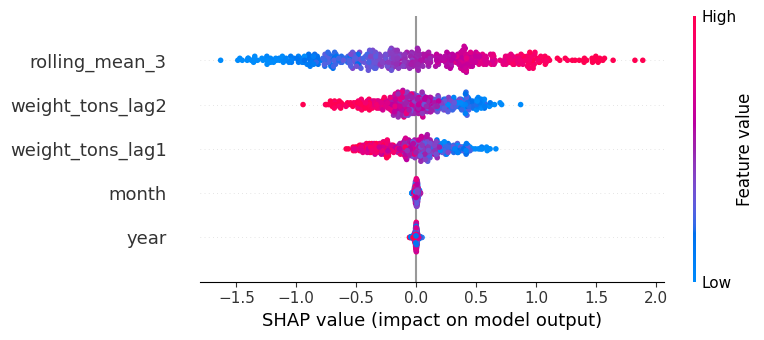

In [ ]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)


To better understand how the Random Forest model makes predictions, I used SHAP (Shapley Additive Explanations). The SHAP summary plot shows how each feature contributes to increasing or decreasing the predicted monthly trash weight.

From the plot, the most important feature is the 3-month rolling average (rolling_mean_3). Higher values of this feature consistently push the prediction upward, which means the model relies strongly on recent trends in trash collection rather than single monthly spikes. This is reasonable for time-series data, where short-term history often carries important information.

The lag features (weight_tons_lag1 and weight_tons_lag2) also have a strong impact. Higher trash amounts in previous months generally lead to higher predictions for the current month. This confirms that recent historical values play a key role in forecasting trash weight.

In contrast, the calendar features (month and year) have much smaller SHAP values. The limited impact of month suggests that seasonality exists but is weaker compared to recent history. The very small impact of year indicates that there is no strong long-term upward or downward trend in trash collection over the dataset.

Overall, the SHAP results show that the Random Forest model mainly learns from recent patterns in the data, which aligns well with the time-series nature of the problem.

# Step 12: Save the Model

In [ ]:
import joblib, json

joblib.dump(rf, "model.joblib")
meta = {"features": features, "model": "Random Forest"}
with open("model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)


I saved the trained Random Forest model using joblib so it can be loaded quickly inside the Streamlit app without retraining. I also stored the feature names in a separate JSON file, which helps the app know which inputs to expect. Together, model.joblib and model_meta.json allow smooth and error-free deployment.

# Step 13: Create a Streamlit App
I build a small web app where users can enter values (month, year, last month’s weight) and get a predicted trash weight.
This covers the deployment part of the assignment.

In [ ]:
import streamlit as st
import pandas as pd
import joblib, json

st.set_page_config(page_title="Trash Wheel Predictor")
st.title("Trash Wheel – Monthly Weight Prediction")

model = joblib.load("model.joblib")
meta = json.load(open("model_meta.json"))
features = meta["features"]          # e.g. ["month","year","weight_tons_lag1","weight_tons_lag2","rolling_mean_3"]

st.sidebar.header("Enter Values")
inp = {}
inp["month"] = st.sidebar.slider("Month (1-12)", 1, 12, 6)
inp["year"] = st.sidebar.number_input("Year", 2024, 2030, 2024)
inp["weight_tons_lag1"] = st.sidebar.number_input("Last Month Weight (tons)", 0.0, 20.0, 5.0)
inp["weight_tons_lag2"] = st.sidebar.number_input("Weight 2 Months Ago (tons)", 0.0, 20.0, 5.0)
inp["rolling_mean_3"] = st.sidebar.number_input("3-Month Rolling Mean (tons)", 0.0, 20.0, 5.0)

X = pd.DataFrame([[inp[f] for f in features]], columns=features)

pred = float(model.predict(X)[0])
st.subheader(f"Predicted Trash Weight: {pred:.2f} tons")


2025-12-16 19:06:31.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 19:06:31.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 19:06:31.980 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 19:06:31.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 19:06:32.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 19:06:32.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 19:06:32.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-16 19:06:32.209 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

# Step 14: Conclusion
I built and evaluated models to predict monthly trash weight using the Trash Wheel dataset. After 
cleaning the data and creating time-based features, I trained Linear Regression and Random Forest.

Although Linear Regression achieved the highest accuracy on the test set, this was mainly because 
the lag features made the relationship almost perfectly linear for that period. Such performance may 
not remain stable when the data pattern changes.

For deployment, I chose **Random Forest** because it is more robust to non-linear patterns, handles 
noise better, and provides clearer explainability through SHAP. These advantages make it a more 
reliable real-world model, even with slightly lower accuracy than the linear model.

Using SHAP, I identified that recent trash values (lag features and rolling mean) have the strongest 
impact on predictions. Finally, I deployed the model using Streamlit to create an interactive tool.

### Key Learnings
- Data cleaning and EDA  
- Feature engineering for time-series  
- Model evaluation and interpretation  
- Explainability with SHAP  
- Deployment using Streamlit  

